In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from matplotlib import pyplot as plt

# ---

# 1. Load the data from CSV files using pandas
# 2. Convert the data to numpy arrays and shuffle for randomness
# 3. Split features and labels
# 4. Convert numpy arrays to PyTorch tensors
# 5. Split into development (dev) and training sets
# 6. Create PyTorch datasets and data loaders for batching

In [3]:
# Load data
datat = pd.read_csv("datasets/mnist_train_small.csv")
datatest = pd.read_csv("datasets/mnist_test.csv")

# Convert to numpy, then to torch tensors
data = np.array(datat)
np.random.shuffle(data) # Shuffle to randomize the order

X = data[:, 1:] / 255.0  # Normalize pixel values to [0, 1]
y = data[:, 0].astype(np.int64) # Labels as integers

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Split into dev and train
X_dev, y_dev = X[:1000], y[:1000] # First 1000 samples for dev/validation
X_train, y_train = X[1000:], y[1000:] # Remaining for training

# Create DataLoaders
train_ds = TensorDataset(X_train, y_train)
dev_ds = TensorDataset(X_dev, y_dev)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True) # Shuffle for training
dev_loader = DataLoader(dev_ds, batch_size=64) # No shuffle for validation

In [4]:
# ---

# Define the neural network model using PyTorch's nn.Module
# This model matches the original: 784 -> 10 (ReLU) -> 10
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 10) # First layer 784 input features, 10 output classes
        self.relu = nn.ReLU() # ReLU activation function
        self.fc2 = nn.Linear(10, 10) # Second layer 10 input features, 10 output classes
    
    def forward(self, x):
        x = self.fc1(x) # Linear transformation
        x = self.relu(x) # Non-linear transformation
        x = self.fc2(x) # Output layer(logits)
        return x  # logits, will apply softmax in loss

In [5]:
# ---

# 1. Set up device (GPU if available, else CPU)
# 2. Define loss function and optimizer
# 3. Training loop: for each epoch, train and then evaluate on dev set

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss() # Combines softmax + cross-entropy
optimizer = optim.SGD(model.parameters(), lr=0.5) # Stochastic Gradient Descent

for epoch in range(10):  # 10 epochs, adjust as needed
    model.train() # Set model to training mode
    for xb, yb in train_loader: # Iterate over batches
        xb, yb = xb.to(device), yb.to(device) # Move to device
        optimizer.zero_grad() # Clear gradients
        out = model(xb) # Forward pass
        loss = criterion(out, yb) # Compute loss
        loss.backward() # Backward pass
        optimizer.step() # Update weights
    # Evaluate on dev set after each epoch
    model.eval() # Set model to evaluation mode
    correct, total = 0, 0
    with torch.no_grad(): # No need to compute gradients during evaluation
        for xb, yb in dev_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            preds = out.argmax(dim=1) # Get predicted class
            correct += (preds == yb).sum().item() # Count correct predictions
            total += yb.size(0)  # Count total samples
    print(f"Epoch {epoch}, Dev accuracy: {correct/total:.4f}")

Epoch 0, Dev accuracy: 0.8380
Epoch 1, Dev accuracy: 0.8800
Epoch 2, Dev accuracy: 0.9100
Epoch 3, Dev accuracy: 0.9220
Epoch 4, Dev accuracy: 0.9220
Epoch 5, Dev accuracy: 0.8830
Epoch 6, Dev accuracy: 0.9130
Epoch 7, Dev accuracy: 0.9170
Epoch 8, Dev accuracy: 0.8950
Epoch 9, Dev accuracy: 0.9060


Prediction: 8, Label: 8


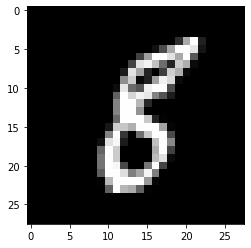

Prediction: 7, Label: 7


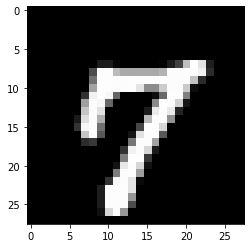

In [6]:
# ---

# Function to visualize a prediction for a given index
# Shows the image, predicted label, and true label
def show_prediction(index):
    img = X_train[index].cpu().numpy().reshape(28, 28) # Reshape flat vector to 28x28 image
    label = y_train[index].item() # True label
    model.eval()
    with torch.no_grad():
        pred = model(X_train[index].unsqueeze(0).to(device)).argmax(dim=1).item() # Model prediction
    print(f"Prediction: {pred}, Label: {label}")
    plt.imshow(img, cmap='gray')
    plt.show()

show_prediction(0)
show_prediction(100)

Prediction: 8, Label: 8


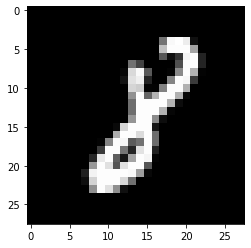

In [10]:
show_prediction()

In [21]:
# (Optional) Show a prediction (example usage)
# show_prediction()  # Uncomment and provide an index if needed

# ---

# This function will display images where the model's prediction does not match the label
# It also keeps track of the number of correct and incorrect predictions
correct = 0
not_correct = 0
def show_wrong_prediction(index):
    global correct
    global not_correct
    img = X_train[index].cpu().numpy().reshape(28, 28)
    label = y_train[index].item()
    model.eval()
    with torch.no_grad():
        pred = model(X_train[index].unsqueeze(0).to(device)).argmax(dim=1).item()
    if pred != label:
        not_correct += 1
        print(f"Index: {index}, Prediction: {pred}, Label: {label}")
        plt.imshow(img, cmap='gray')
        plt.show()
    else:
        correct += 1

Index: 1, Prediction: 0, Label: 3


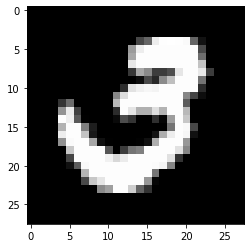

Index: 9, Prediction: 9, Label: 3


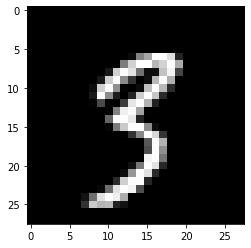

Index: 11, Prediction: 5, Label: 8


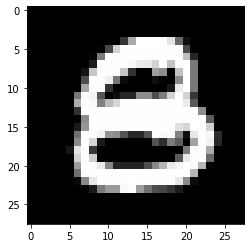

Index: 13, Prediction: 9, Label: 8


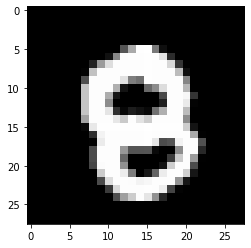

Index: 24, Prediction: 8, Label: 2


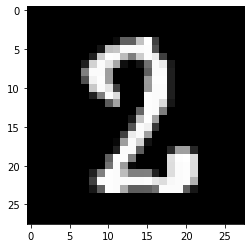

Index: 26, Prediction: 7, Label: 9


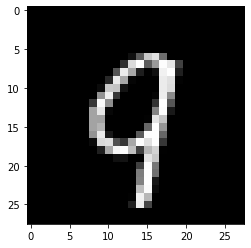

Index: 28, Prediction: 5, Label: 3


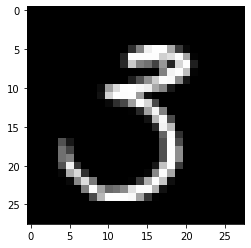

Index: 41, Prediction: 3, Label: 5


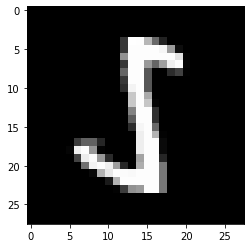

Index: 48, Prediction: 8, Label: 5


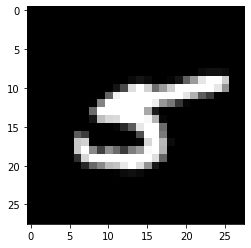

Index: 84, Prediction: 8, Label: 2


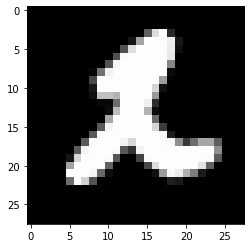

Index: 113, Prediction: 3, Label: 8


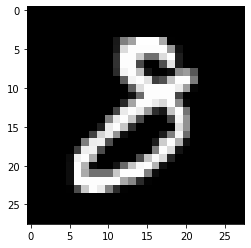

Index: 150, Prediction: 0, Label: 5


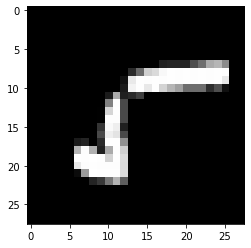

Index: 153, Prediction: 3, Label: 2


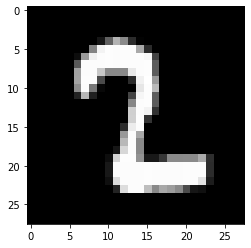

Index: 154, Prediction: 8, Label: 2


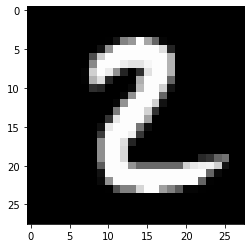

Index: 160, Prediction: 8, Label: 1


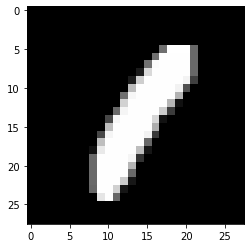

Index: 182, Prediction: 3, Label: 9


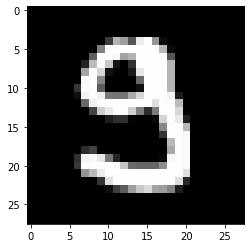

Index: 186, Prediction: 5, Label: 3


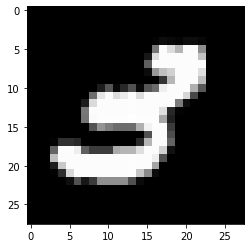

Index: 197, Prediction: 3, Label: 8


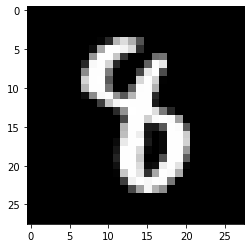

Index: 198, Prediction: 9, Label: 4


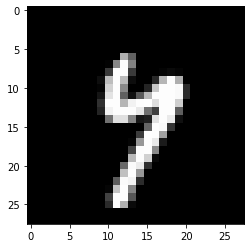

Index: 203, Prediction: 4, Label: 9


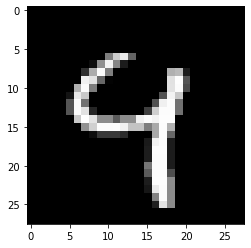

Index: 209, Prediction: 9, Label: 4


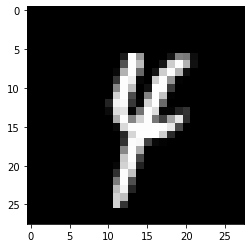

Index: 211, Prediction: 9, Label: 8


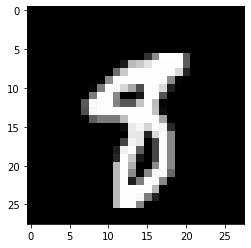

Index: 232, Prediction: 4, Label: 6


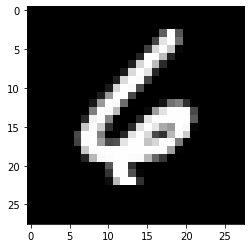

Index: 264, Prediction: 3, Label: 2


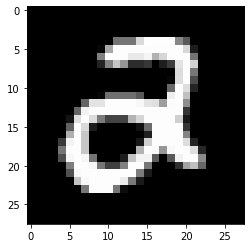

Index: 270, Prediction: 7, Label: 9


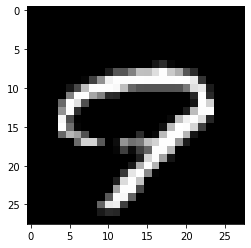

Index: 287, Prediction: 9, Label: 4


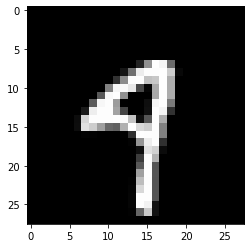

Index: 302, Prediction: 9, Label: 4


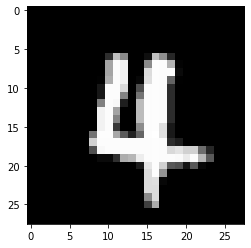

Index: 357, Prediction: 9, Label: 4


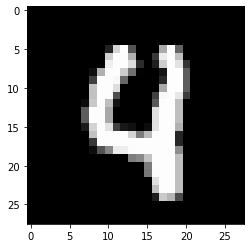

Index: 359, Prediction: 8, Label: 0


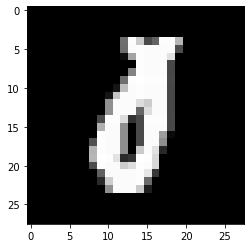

Index: 360, Prediction: 7, Label: 2


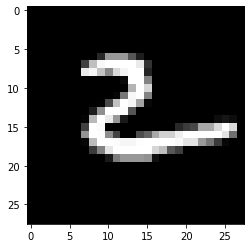

Index: 368, Prediction: 9, Label: 4


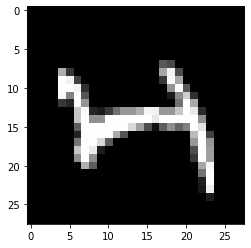

Index: 382, Prediction: 5, Label: 3


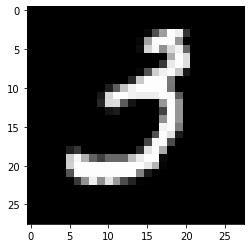

Index: 394, Prediction: 9, Label: 4


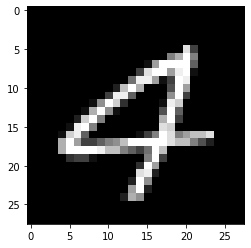

Index: 401, Prediction: 7, Label: 2


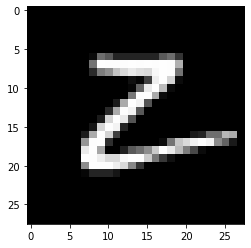

Index: 420, Prediction: 0, Label: 2


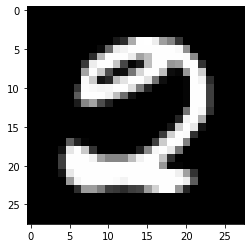

Index: 436, Prediction: 9, Label: 4


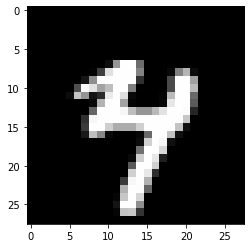

Index: 440, Prediction: 8, Label: 1


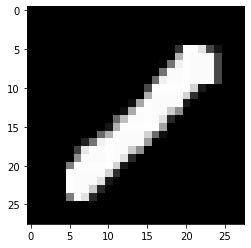

Index: 441, Prediction: 5, Label: 3


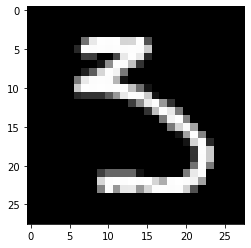

Index: 442, Prediction: 8, Label: 6


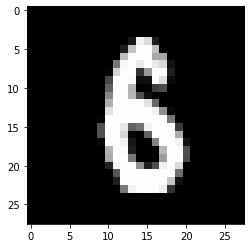

Index: 443, Prediction: 9, Label: 7


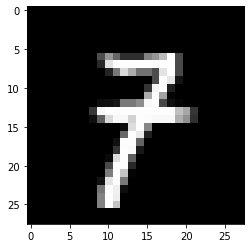

Index: 451, Prediction: 7, Label: 3


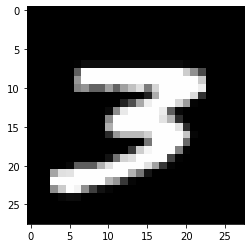

Index: 456, Prediction: 5, Label: 3


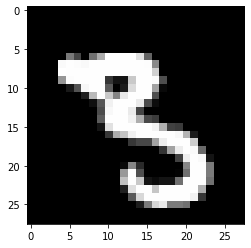

Index: 460, Prediction: 4, Label: 6


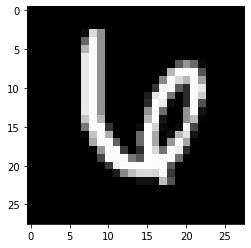

Index: 471, Prediction: 9, Label: 3


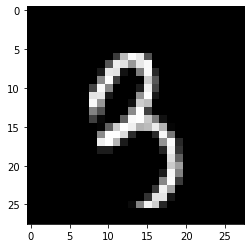

Index: 478, Prediction: 9, Label: 8


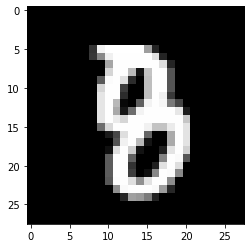

Index: 495, Prediction: 0, Label: 8


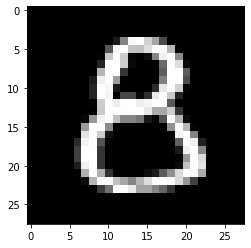

Index: 507, Prediction: 7, Label: 9


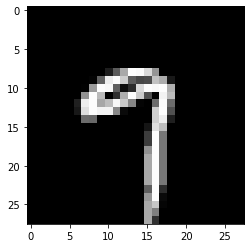

Index: 514, Prediction: 3, Label: 5


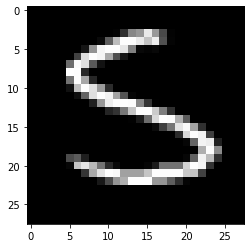

Index: 518, Prediction: 7, Label: 9


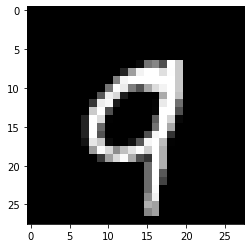

Index: 522, Prediction: 6, Label: 1


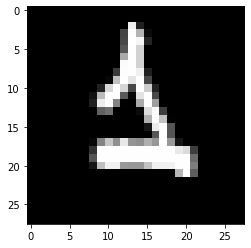

Index: 548, Prediction: 4, Label: 6


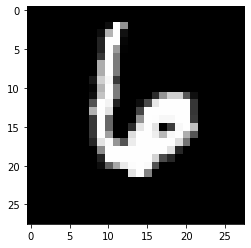

Index: 550, Prediction: 9, Label: 7


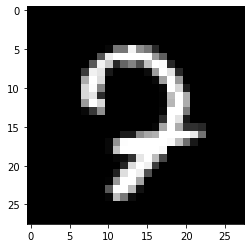

Index: 578, Prediction: 8, Label: 3


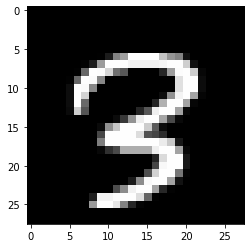

Index: 587, Prediction: 9, Label: 4


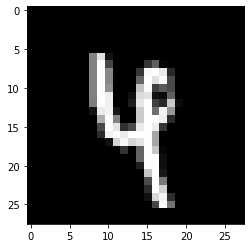

Index: 589, Prediction: 9, Label: 4


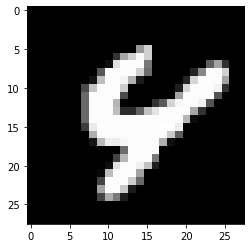

Index: 605, Prediction: 6, Label: 2


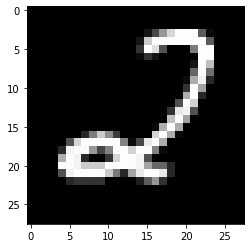

Index: 654, Prediction: 7, Label: 3


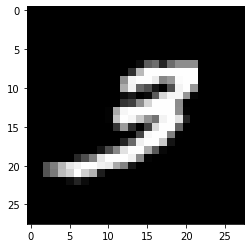

Index: 676, Prediction: 8, Label: 5


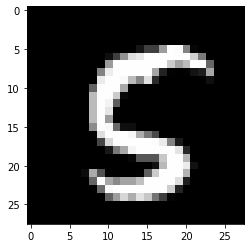

Index: 681, Prediction: 5, Label: 3


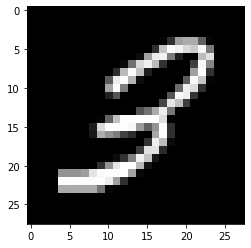

Index: 687, Prediction: 7, Label: 9


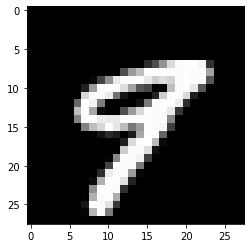

Index: 696, Prediction: 5, Label: 3


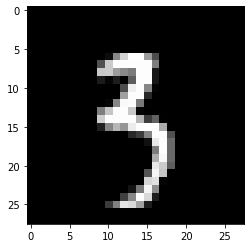

Index: 703, Prediction: 9, Label: 4


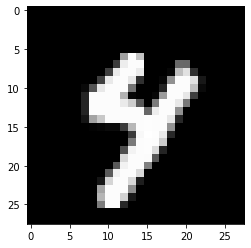

Index: 710, Prediction: 7, Label: 3


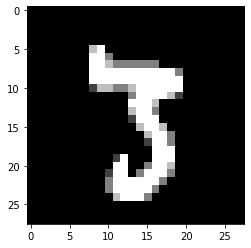

Index: 716, Prediction: 5, Label: 3


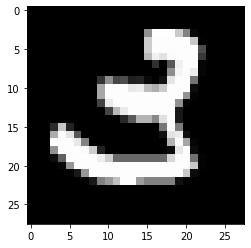

Index: 728, Prediction: 9, Label: 3


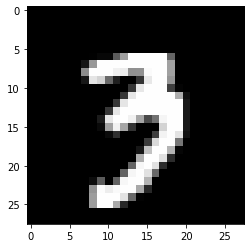

Index: 753, Prediction: 5, Label: 3


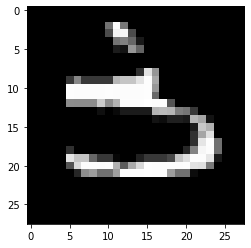

Index: 784, Prediction: 3, Label: 2


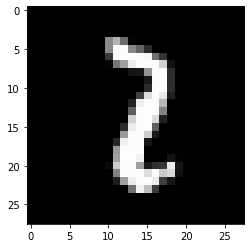

Index: 805, Prediction: 8, Label: 5


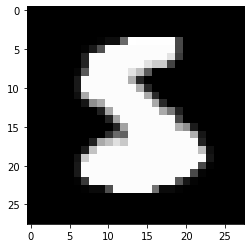

Index: 812, Prediction: 3, Label: 8


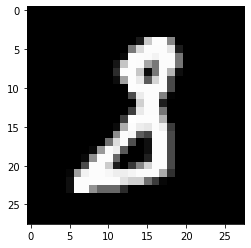

Index: 823, Prediction: 7, Label: 5


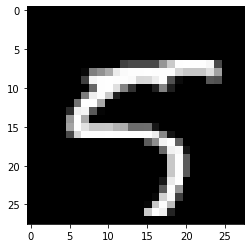

Index: 836, Prediction: 8, Label: 2


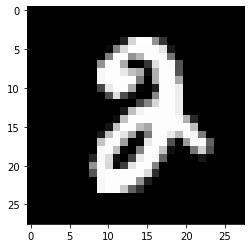

Index: 863, Prediction: 5, Label: 3


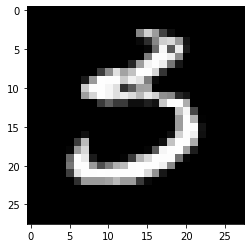

Index: 899, Prediction: 5, Label: 3


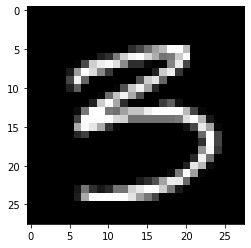

Index: 904, Prediction: 9, Label: 8


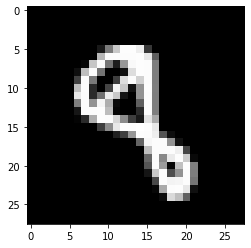

Index: 917, Prediction: 9, Label: 4


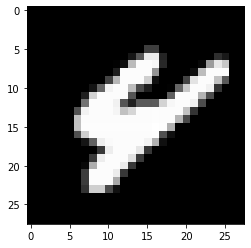

Index: 922, Prediction: 8, Label: 5


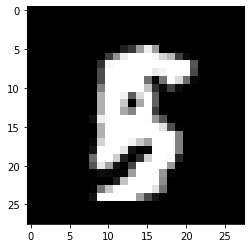

Index: 930, Prediction: 3, Label: 8


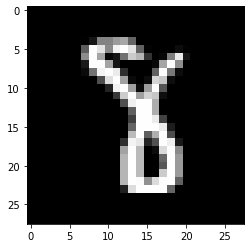

Index: 934, Prediction: 9, Label: 4


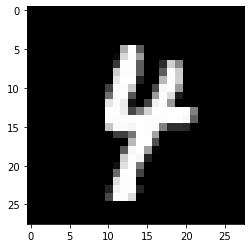

Index: 935, Prediction: 7, Label: 9


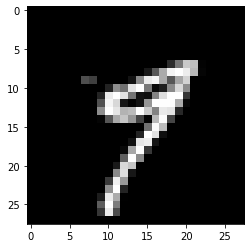

Index: 939, Prediction: 5, Label: 3


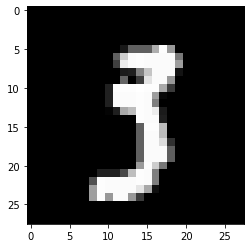

Index: 948, Prediction: 5, Label: 8


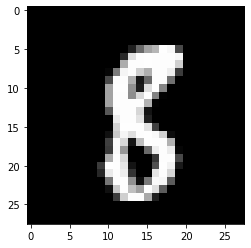

Index: 955, Prediction: 3, Label: 2


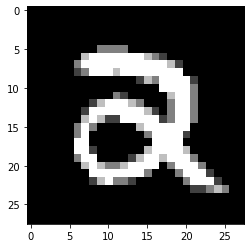

Index: 956, Prediction: 9, Label: 4


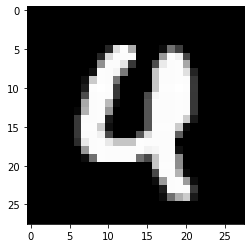

Index: 958, Prediction: 8, Label: 3


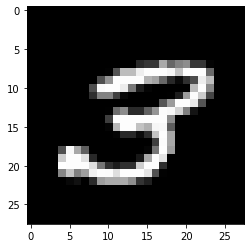

Index: 990, Prediction: 7, Label: 8


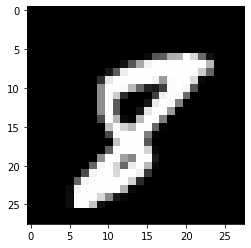

Index: 1003, Prediction: 9, Label: 3


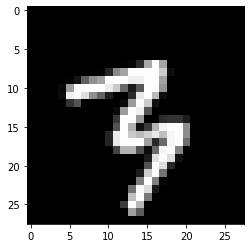

Index: 1005, Prediction: 4, Label: 6


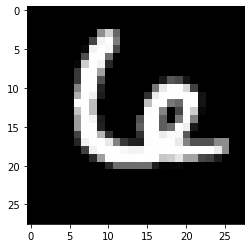

Index: 1016, Prediction: 9, Label: 4


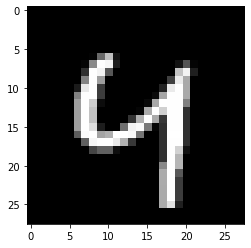

Index: 1033, Prediction: 0, Label: 8


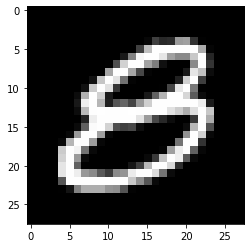

Index: 1052, Prediction: 9, Label: 7


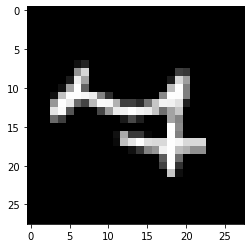

Index: 1078, Prediction: 4, Label: 9


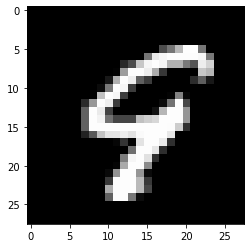

Index: 1098, Prediction: 4, Label: 7


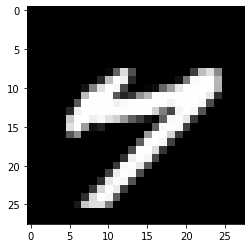

Index: 1103, Prediction: 8, Label: 5


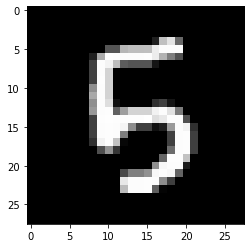

Index: 1164, Prediction: 2, Label: 1


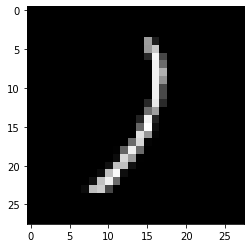

Index: 1165, Prediction: 6, Label: 8


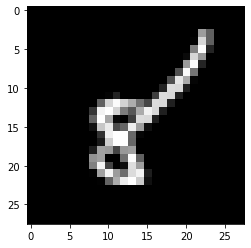

Index: 1193, Prediction: 5, Label: 3


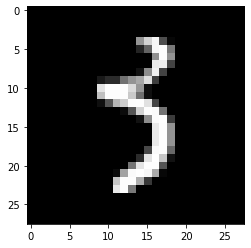

Index: 1205, Prediction: 7, Label: 9


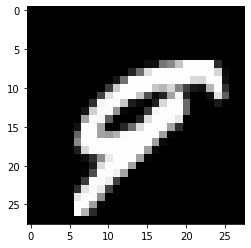

Index: 1206, Prediction: 7, Label: 5


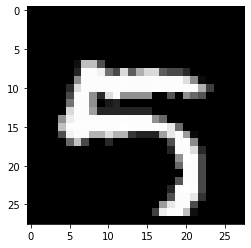

Index: 1238, Prediction: 7, Label: 8


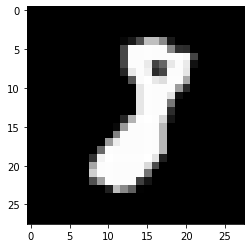

Index: 1259, Prediction: 2, Label: 3


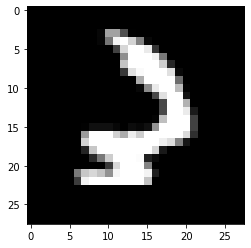

Index: 1260, Prediction: 5, Label: 3


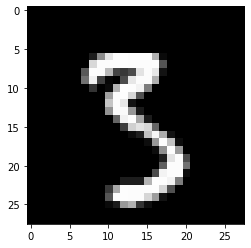

Index: 1273, Prediction: 0, Label: 5


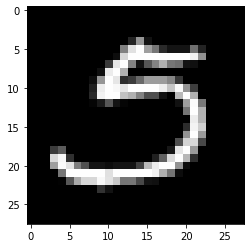

Index: 1290, Prediction: 5, Label: 0


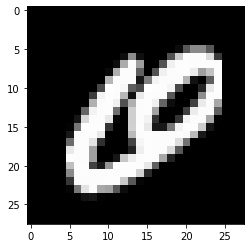

Index: 1306, Prediction: 9, Label: 0


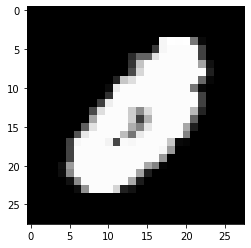

Index: 1337, Prediction: 7, Label: 9


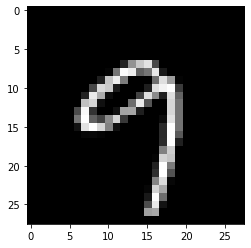

Index: 1344, Prediction: 8, Label: 5


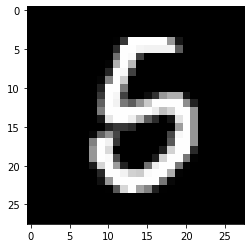

Index: 1364, Prediction: 3, Label: 5


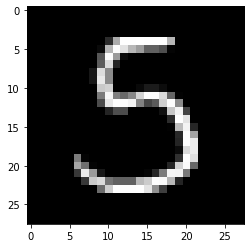

Index: 1388, Prediction: 5, Label: 3


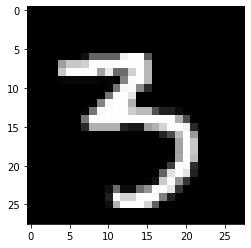

Index: 1415, Prediction: 9, Label: 3


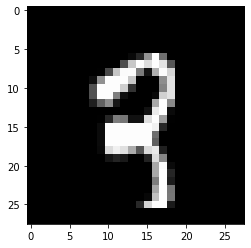

Index: 1422, Prediction: 9, Label: 2


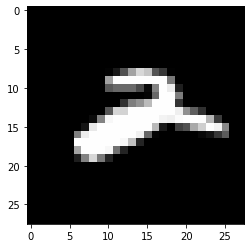

Index: 1437, Prediction: 7, Label: 9


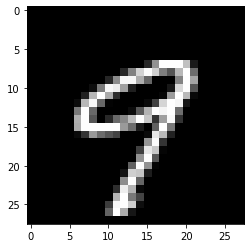

Index: 1460, Prediction: 4, Label: 5


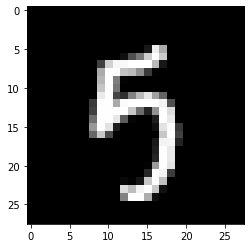

Index: 1477, Prediction: 6, Label: 5


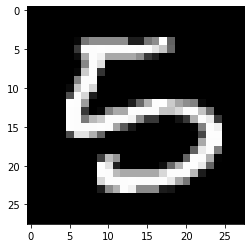

Index: 1495, Prediction: 7, Label: 8


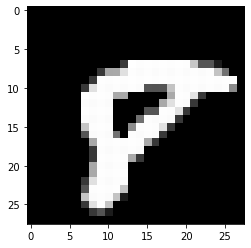

Index: 1506, Prediction: 7, Label: 3


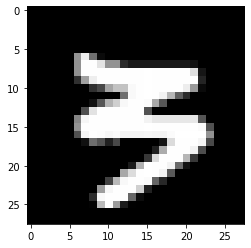

Index: 1590, Prediction: 9, Label: 5


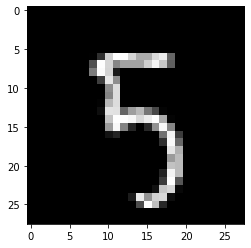

Index: 1601, Prediction: 7, Label: 9


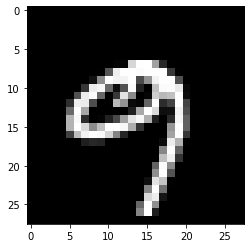

Index: 1610, Prediction: 8, Label: 6


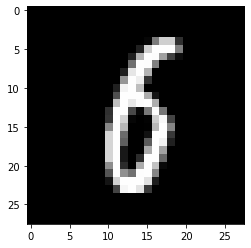

Index: 1616, Prediction: 9, Label: 8


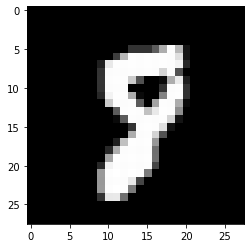

Index: 1618, Prediction: 9, Label: 8


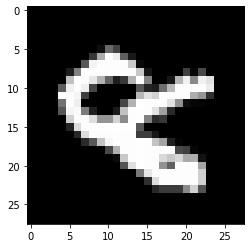

Index: 1628, Prediction: 9, Label: 3


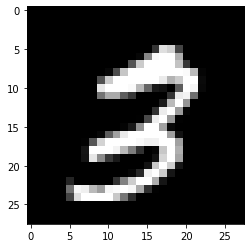

Index: 1630, Prediction: 8, Label: 6


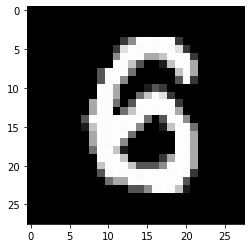

Index: 1634, Prediction: 9, Label: 4


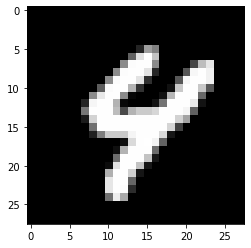

Index: 1643, Prediction: 7, Label: 0


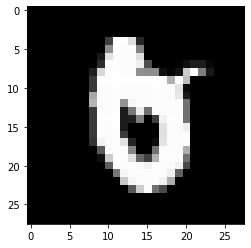

Index: 1655, Prediction: 3, Label: 2


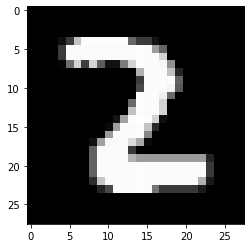

Index: 1657, Prediction: 3, Label: 2


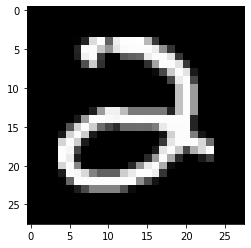

Index: 1661, Prediction: 9, Label: 4


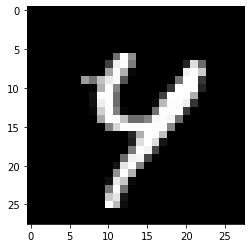

Index: 1677, Prediction: 9, Label: 4


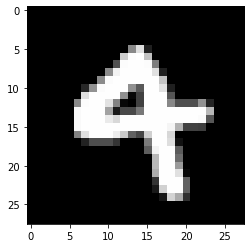

Index: 1698, Prediction: 3, Label: 8


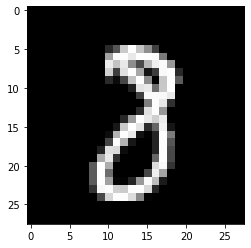

Index: 1702, Prediction: 5, Label: 3


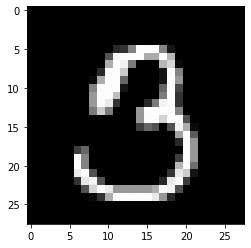

Index: 1703, Prediction: 9, Label: 0


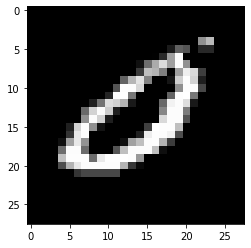

Index: 1707, Prediction: 7, Label: 5


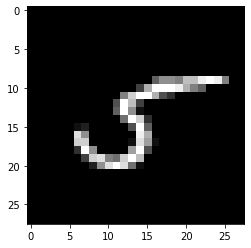

Index: 1733, Prediction: 8, Label: 2


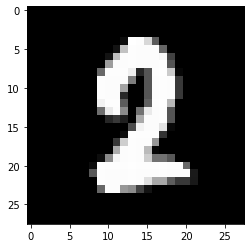

Index: 1750, Prediction: 4, Label: 6


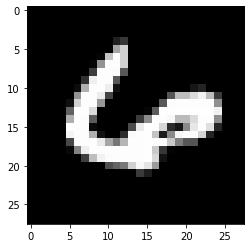

Index: 1766, Prediction: 5, Label: 3


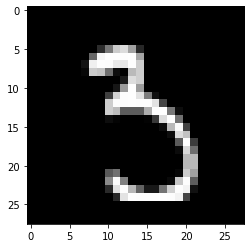

Index: 1772, Prediction: 3, Label: 5


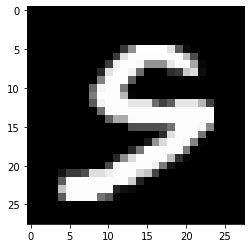

Index: 1783, Prediction: 8, Label: 1


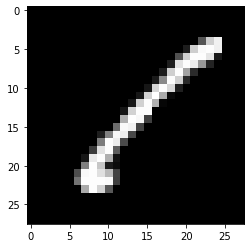

Index: 1799, Prediction: 3, Label: 1


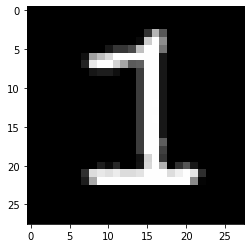

Index: 1813, Prediction: 8, Label: 5


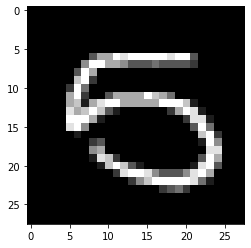

Index: 1837, Prediction: 6, Label: 4


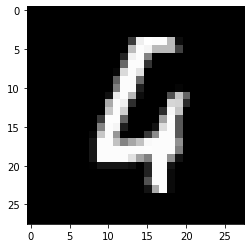

Index: 1854, Prediction: 1, Label: 8


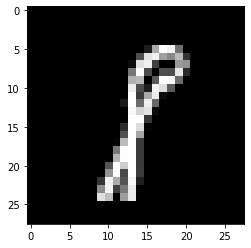

Index: 1860, Prediction: 7, Label: 9


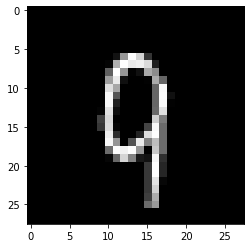

Index: 1862, Prediction: 8, Label: 4


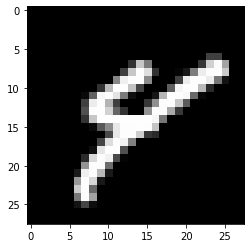

Index: 1864, Prediction: 0, Label: 4


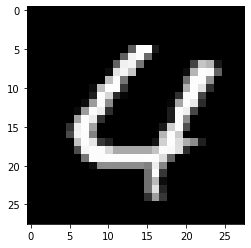

Index: 1870, Prediction: 4, Label: 2


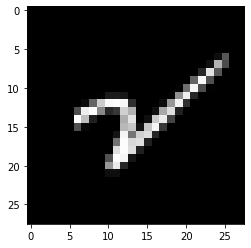

Index: 1888, Prediction: 5, Label: 8


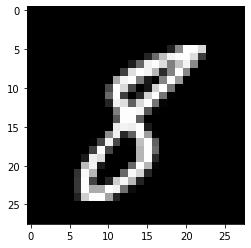

Index: 1913, Prediction: 4, Label: 5


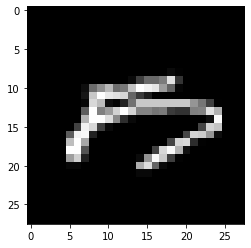

Index: 1924, Prediction: 3, Label: 2


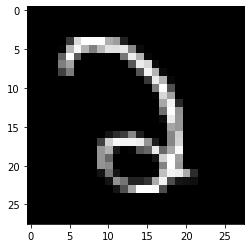

Index: 1962, Prediction: 4, Label: 2


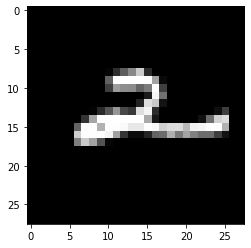

Index: 1967, Prediction: 3, Label: 6


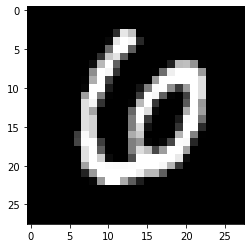

Index: 1984, Prediction: 7, Label: 9


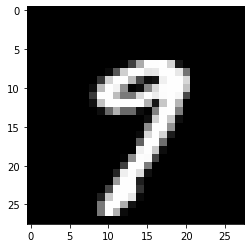

Index: 1997, Prediction: 3, Label: 2


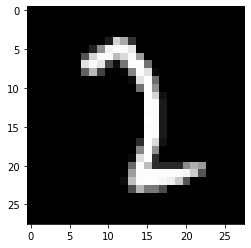

Index: 2009, Prediction: 3, Label: 2


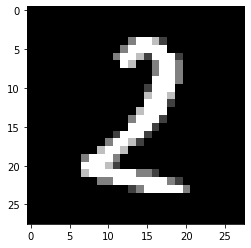

Index: 2017, Prediction: 5, Label: 2


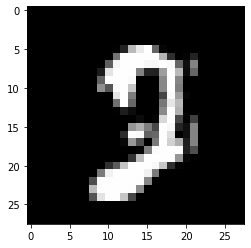

Index: 2027, Prediction: 4, Label: 5


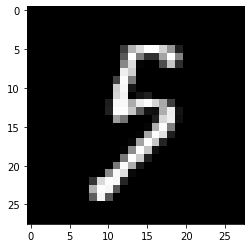

Index: 2041, Prediction: 1, Label: 8


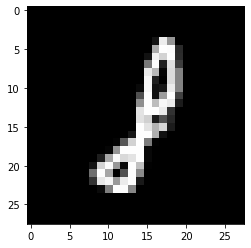

Index: 2059, Prediction: 9, Label: 5


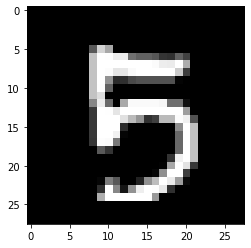

Index: 2064, Prediction: 7, Label: 0


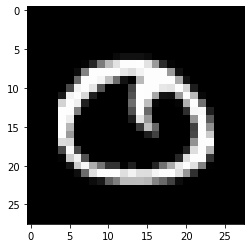

Index: 2070, Prediction: 0, Label: 2


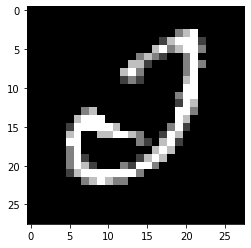

Index: 2108, Prediction: 0, Label: 6


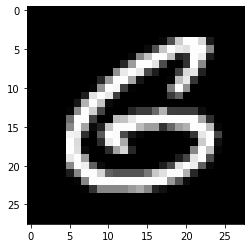

Index: 2128, Prediction: 4, Label: 6


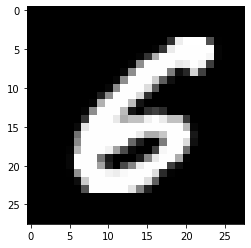

Index: 2139, Prediction: 5, Label: 3


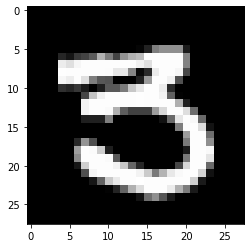

Index: 2145, Prediction: 4, Label: 2


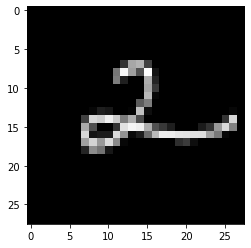

Index: 2167, Prediction: 2, Label: 6


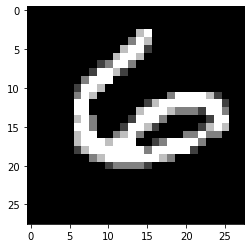

Index: 2196, Prediction: 8, Label: 1


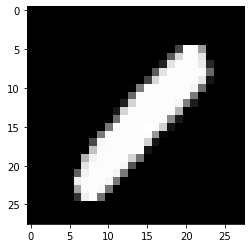

Index: 2206, Prediction: 4, Label: 7


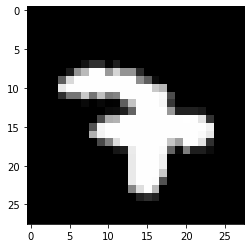

Index: 2218, Prediction: 2, Label: 8


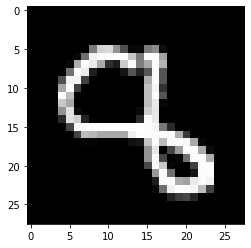

Index: 2231, Prediction: 9, Label: 4


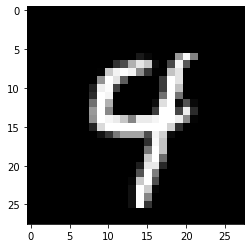

Index: 2242, Prediction: 9, Label: 4


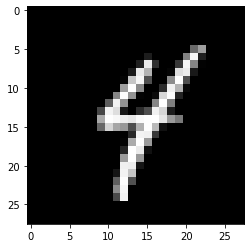

Index: 2243, Prediction: 8, Label: 4


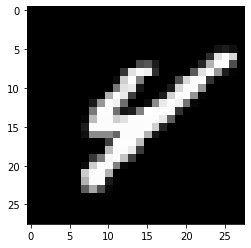

Index: 2268, Prediction: 4, Label: 1


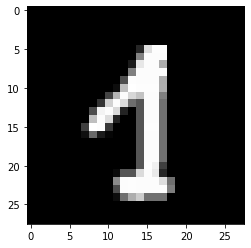

Index: 2269, Prediction: 8, Label: 5


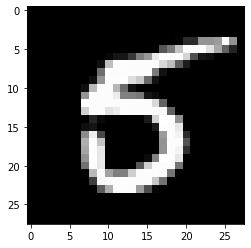

Index: 2318, Prediction: 9, Label: 4


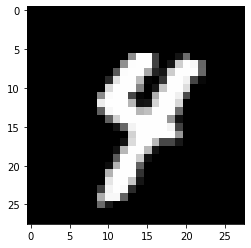

Index: 2345, Prediction: 9, Label: 4


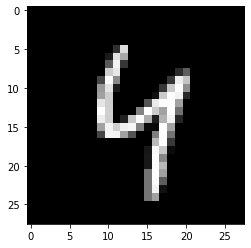

Index: 2362, Prediction: 8, Label: 6


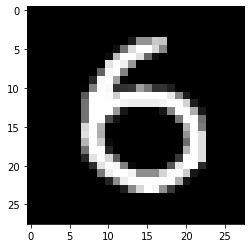

Index: 2371, Prediction: 8, Label: 2


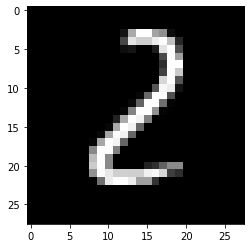

Index: 2376, Prediction: 1, Label: 8


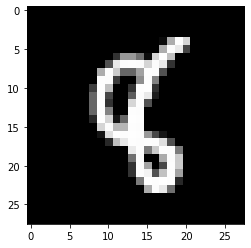

Index: 2395, Prediction: 7, Label: 2


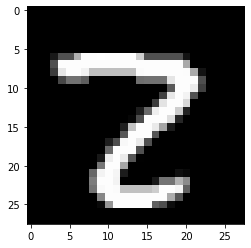

Index: 2403, Prediction: 9, Label: 8


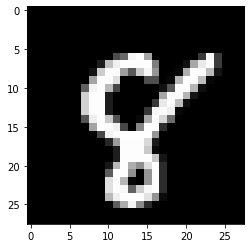

Index: 2409, Prediction: 4, Label: 6


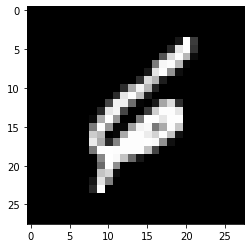

Index: 2410, Prediction: 3, Label: 2


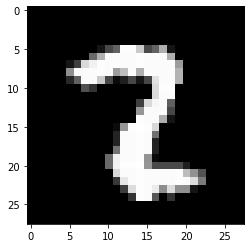

Index: 2424, Prediction: 9, Label: 5


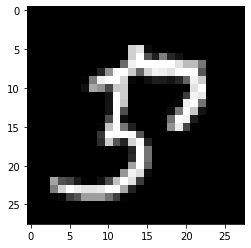

Index: 2447, Prediction: 4, Label: 6


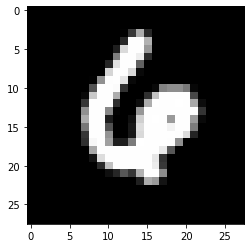

Index: 2449, Prediction: 4, Label: 9


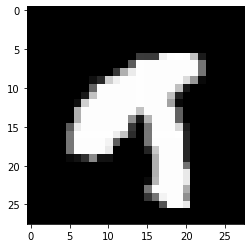

Index: 2456, Prediction: 9, Label: 3


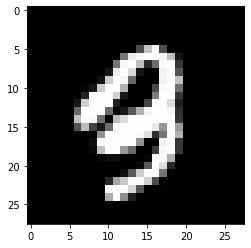

Index: 2458, Prediction: 9, Label: 4


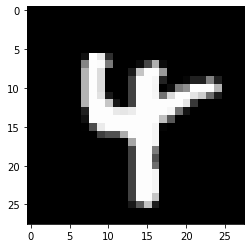

Index: 2460, Prediction: 9, Label: 7


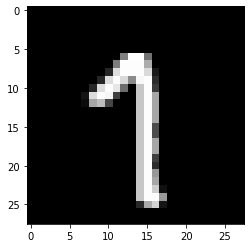

Index: 2498, Prediction: 0, Label: 9


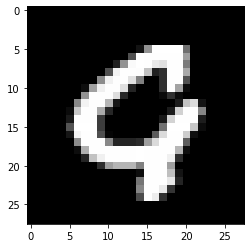

Index: 2542, Prediction: 9, Label: 1


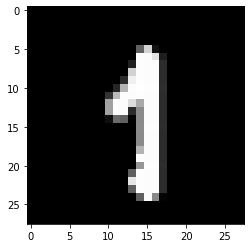

Index: 2547, Prediction: 1, Label: 8


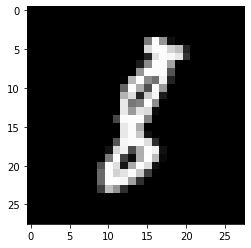

Index: 2553, Prediction: 9, Label: 5


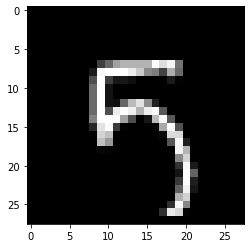

Index: 2575, Prediction: 9, Label: 1


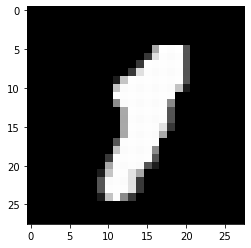

Index: 2593, Prediction: 8, Label: 2


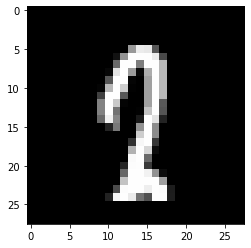

Index: 2594, Prediction: 7, Label: 9


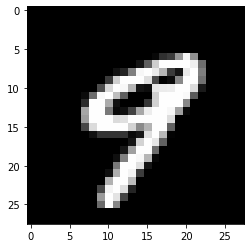

Index: 2618, Prediction: 7, Label: 2


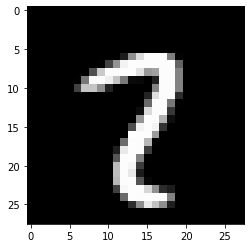

Index: 2627, Prediction: 3, Label: 2


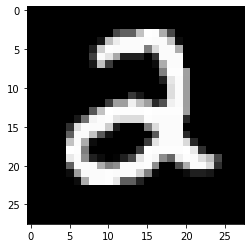

Index: 2629, Prediction: 7, Label: 3


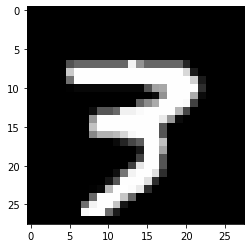

Index: 2634, Prediction: 8, Label: 6


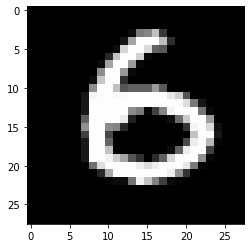

Index: 2641, Prediction: 4, Label: 2


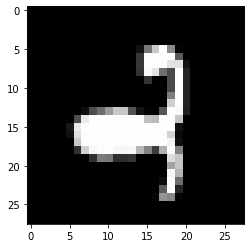

Index: 2657, Prediction: 9, Label: 0


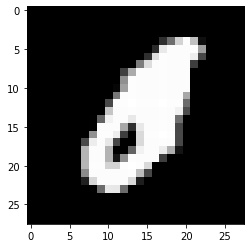

Index: 2658, Prediction: 9, Label: 5


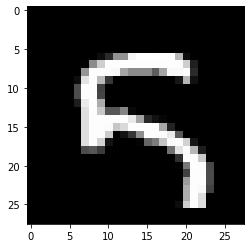

Index: 2660, Prediction: 2, Label: 8


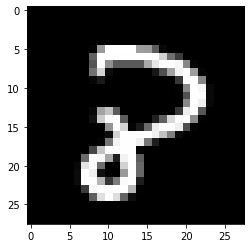

Index: 2675, Prediction: 0, Label: 6


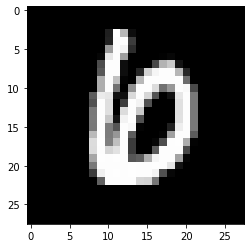

Index: 2686, Prediction: 6, Label: 5


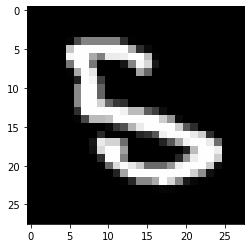

Index: 2709, Prediction: 9, Label: 1


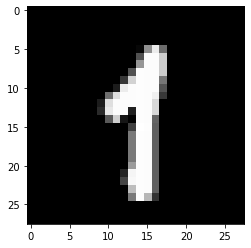

Index: 2715, Prediction: 7, Label: 3


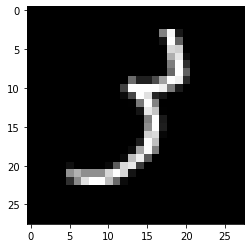

Index: 2739, Prediction: 8, Label: 2


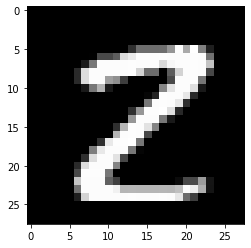

Index: 2748, Prediction: 5, Label: 3


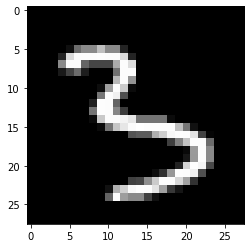

Index: 2781, Prediction: 8, Label: 5


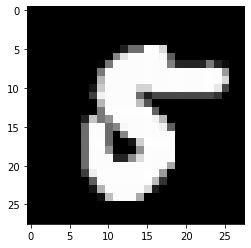

Index: 2794, Prediction: 9, Label: 5


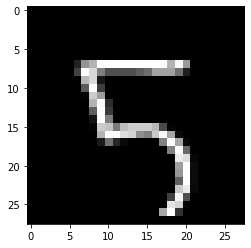

Index: 2810, Prediction: 2, Label: 1


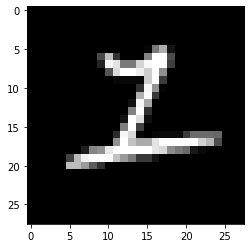

Index: 2834, Prediction: 9, Label: 0


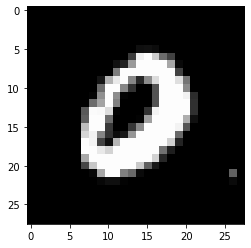

Index: 2838, Prediction: 7, Label: 2


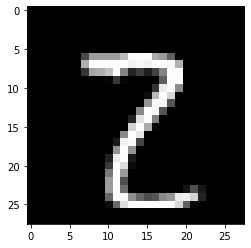

Index: 2839, Prediction: 5, Label: 3


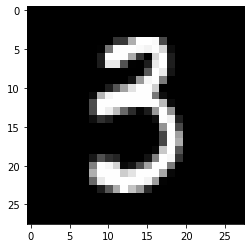

Index: 2850, Prediction: 7, Label: 8


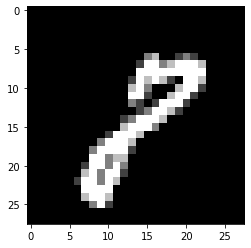

Index: 2860, Prediction: 8, Label: 5


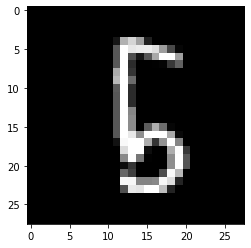

Index: 2876, Prediction: 4, Label: 2


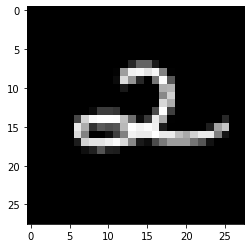

Index: 2886, Prediction: 0, Label: 2


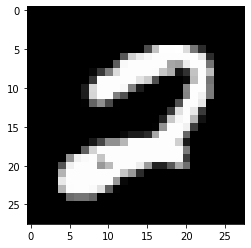

Index: 2896, Prediction: 9, Label: 8


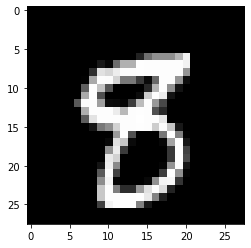

Index: 2911, Prediction: 3, Label: 2


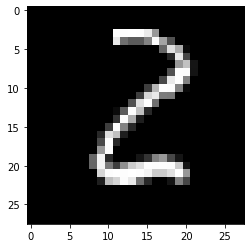

Index: 2943, Prediction: 9, Label: 8


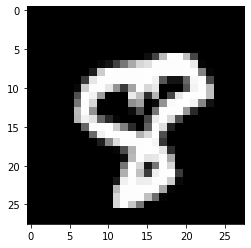

Index: 2976, Prediction: 9, Label: 6


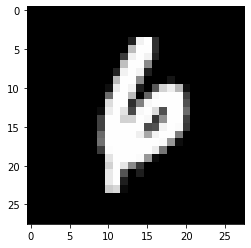

Index: 2984, Prediction: 9, Label: 4


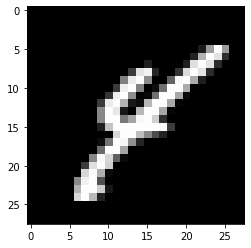

Index: 2987, Prediction: 9, Label: 5


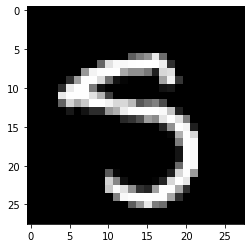

Index: 3002, Prediction: 7, Label: 5


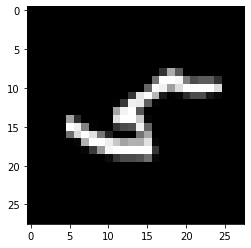

Index: 3008, Prediction: 8, Label: 0


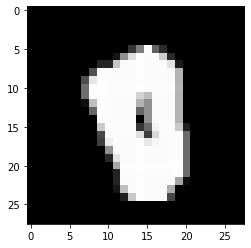

Index: 3052, Prediction: 0, Label: 6


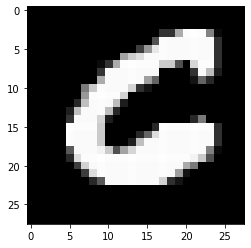

Index: 3081, Prediction: 4, Label: 6


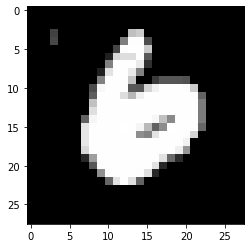

Index: 3085, Prediction: 9, Label: 4


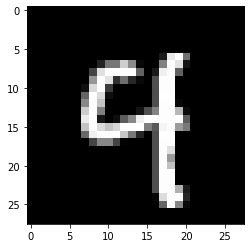

Index: 3088, Prediction: 8, Label: 5


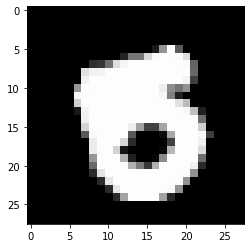

Index: 3089, Prediction: 7, Label: 3


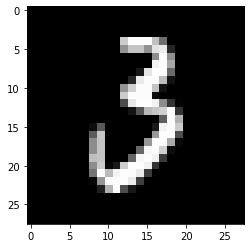

Index: 3090, Prediction: 8, Label: 5


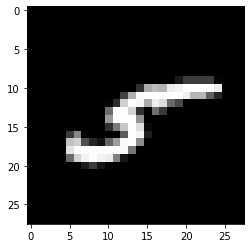

Index: 3091, Prediction: 9, Label: 4


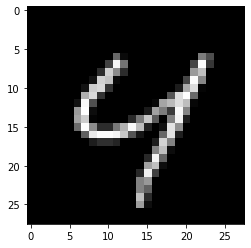

Index: 3115, Prediction: 9, Label: 3


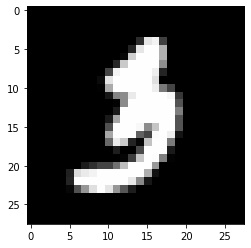

Index: 3147, Prediction: 9, Label: 4


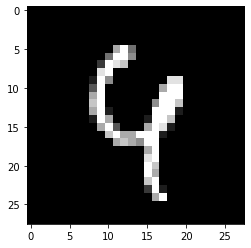

Index: 3159, Prediction: 9, Label: 8


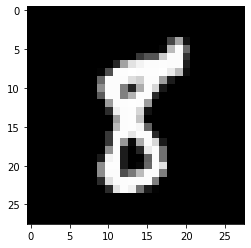

Index: 3171, Prediction: 9, Label: 4


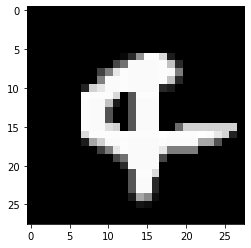

Index: 3177, Prediction: 8, Label: 0


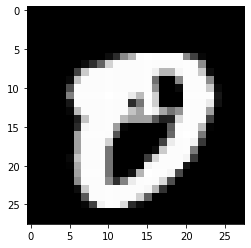

Index: 3188, Prediction: 6, Label: 2


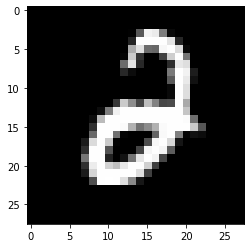

Index: 3203, Prediction: 0, Label: 2


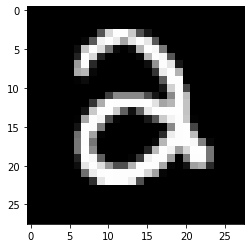

Index: 3241, Prediction: 8, Label: 6


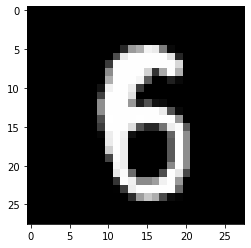

Index: 3243, Prediction: 7, Label: 3


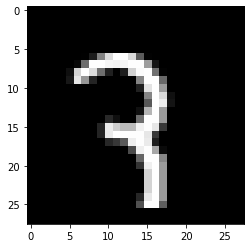

Index: 3270, Prediction: 0, Label: 9


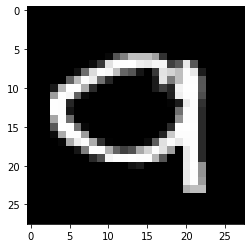

Index: 3281, Prediction: 0, Label: 4


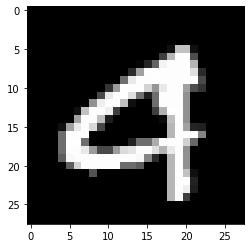

Index: 3314, Prediction: 9, Label: 4


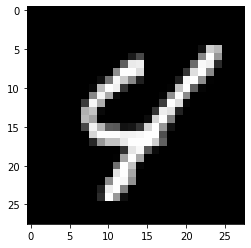

Index: 3348, Prediction: 9, Label: 1


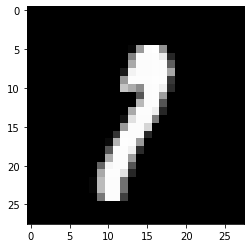

Index: 3371, Prediction: 0, Label: 6


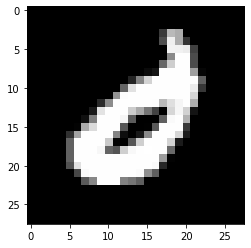

Index: 3379, Prediction: 4, Label: 2


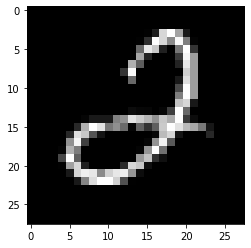

Index: 3386, Prediction: 3, Label: 2


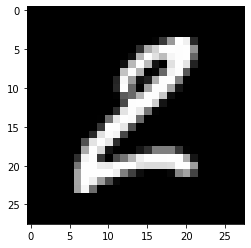

Index: 3391, Prediction: 9, Label: 4


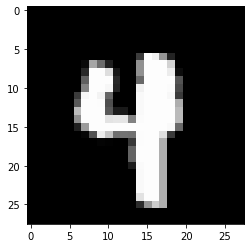

Index: 3419, Prediction: 7, Label: 4


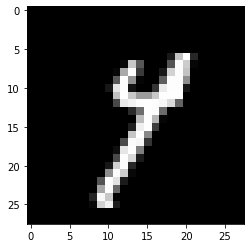

Index: 3428, Prediction: 8, Label: 5


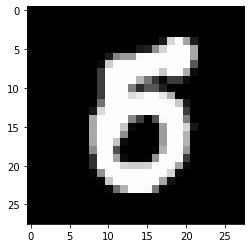

Index: 3476, Prediction: 3, Label: 5


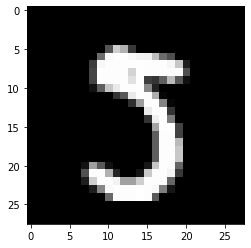

Index: 3491, Prediction: 1, Label: 8


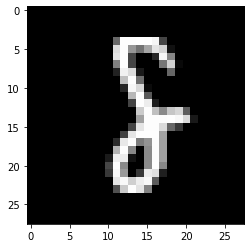

Index: 3521, Prediction: 7, Label: 8


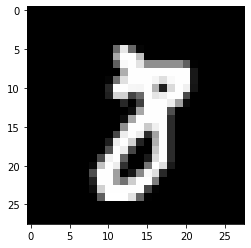

Index: 3541, Prediction: 5, Label: 3


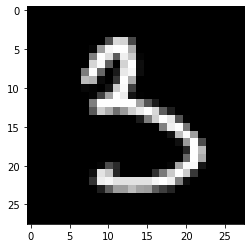

Index: 3549, Prediction: 5, Label: 3


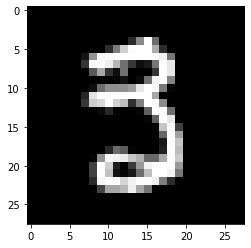

Index: 3557, Prediction: 7, Label: 0


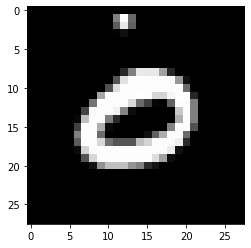

Index: 3563, Prediction: 3, Label: 0


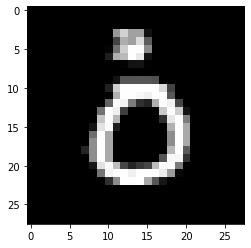

Index: 3571, Prediction: 5, Label: 8


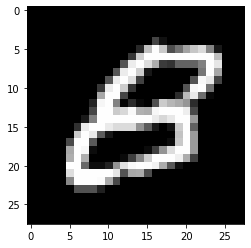

Index: 3585, Prediction: 0, Label: 2


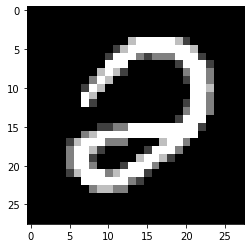

Index: 3596, Prediction: 8, Label: 5


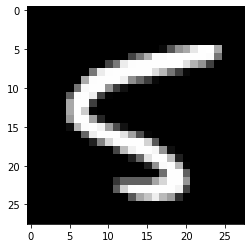

Index: 3621, Prediction: 6, Label: 1


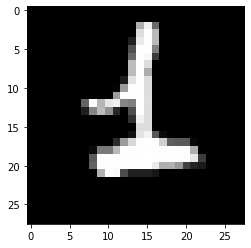

Index: 3624, Prediction: 4, Label: 6


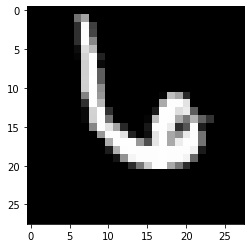

Index: 3632, Prediction: 1, Label: 7


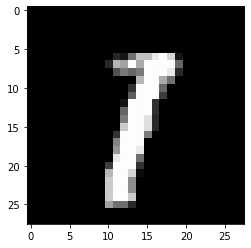

Index: 3638, Prediction: 2, Label: 3


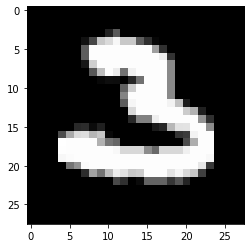

Index: 3640, Prediction: 8, Label: 1


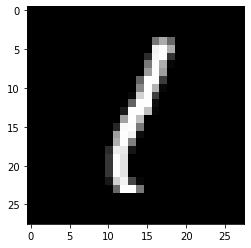

Index: 3649, Prediction: 1, Label: 8


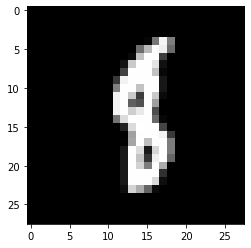

Index: 3654, Prediction: 2, Label: 3


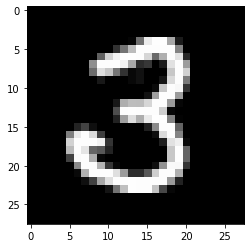

Index: 3689, Prediction: 7, Label: 9


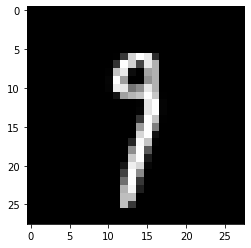

Index: 3703, Prediction: 3, Label: 5


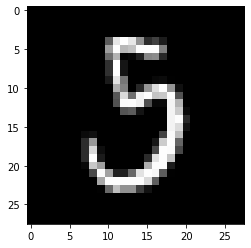

Index: 3736, Prediction: 6, Label: 5


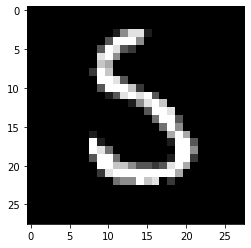

Index: 3739, Prediction: 4, Label: 6


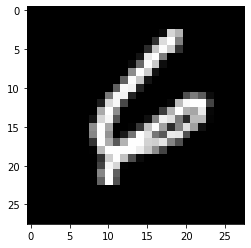

Index: 3749, Prediction: 9, Label: 4


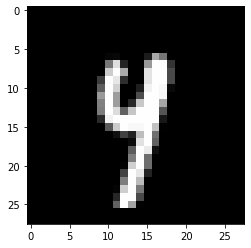

Index: 3764, Prediction: 1, Label: 8


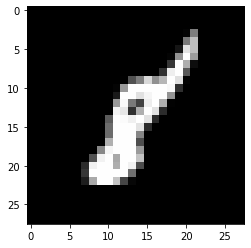

Index: 3766, Prediction: 8, Label: 2


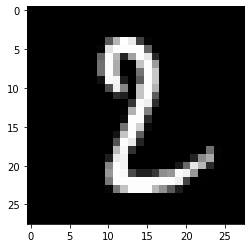

Index: 3778, Prediction: 8, Label: 2


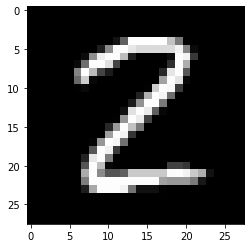

Index: 3809, Prediction: 9, Label: 4


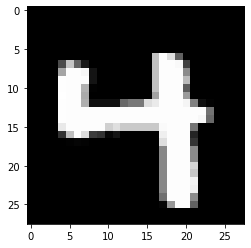

Index: 3811, Prediction: 5, Label: 3


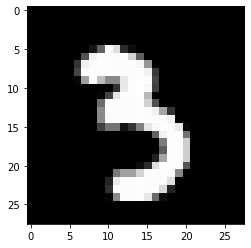

Index: 3815, Prediction: 0, Label: 5


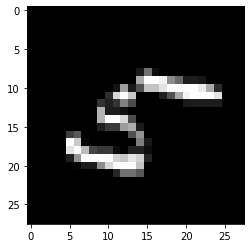

Index: 3818, Prediction: 7, Label: 5


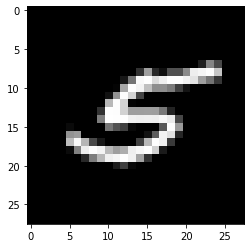

Index: 3819, Prediction: 4, Label: 1


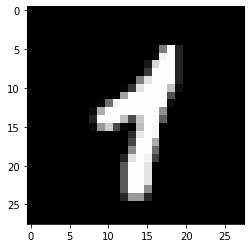

Index: 3823, Prediction: 0, Label: 2


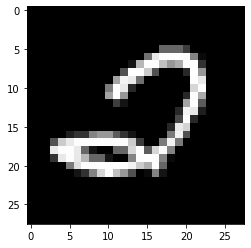

Index: 3824, Prediction: 0, Label: 6


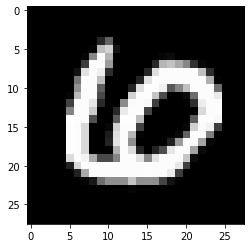

Index: 3841, Prediction: 3, Label: 8


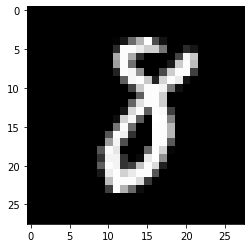

Index: 3857, Prediction: 1, Label: 8


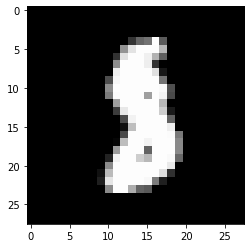

Index: 3865, Prediction: 7, Label: 2


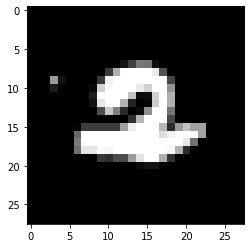

Index: 3874, Prediction: 9, Label: 8


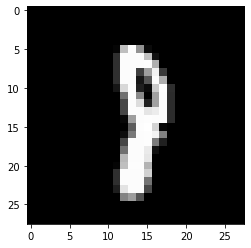

Index: 3901, Prediction: 5, Label: 3


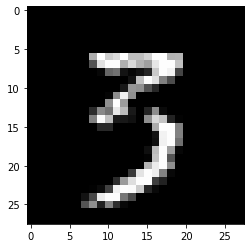

Index: 3939, Prediction: 9, Label: 4


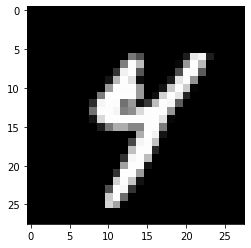

Index: 3948, Prediction: 3, Label: 2


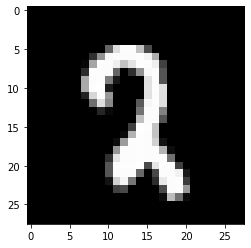

Index: 3959, Prediction: 7, Label: 2


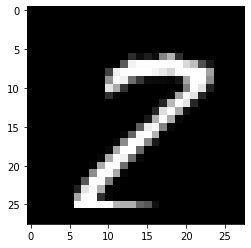

Index: 3965, Prediction: 9, Label: 3


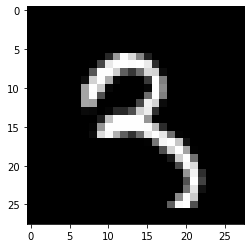

Index: 3975, Prediction: 3, Label: 5


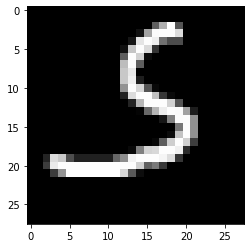

Index: 3978, Prediction: 4, Label: 6


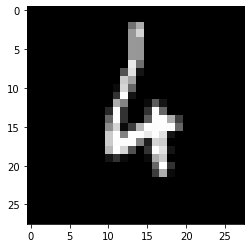

Index: 4001, Prediction: 7, Label: 2


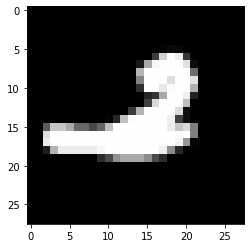

Index: 4016, Prediction: 8, Label: 5


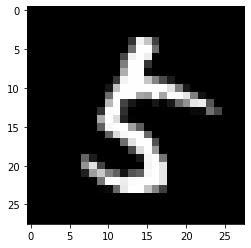

Index: 4043, Prediction: 5, Label: 3


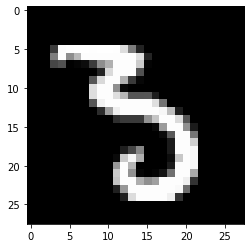

Index: 4063, Prediction: 8, Label: 3


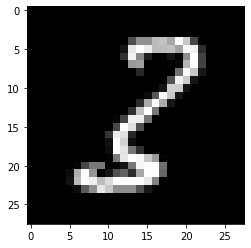

Index: 4068, Prediction: 8, Label: 2


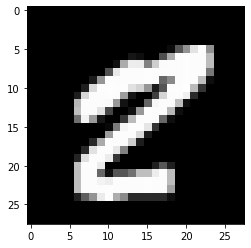

Index: 4071, Prediction: 0, Label: 6


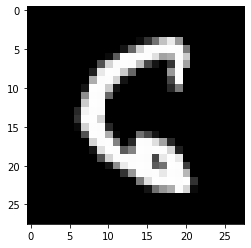

Index: 4082, Prediction: 8, Label: 1


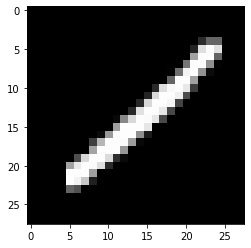

Index: 4120, Prediction: 3, Label: 2


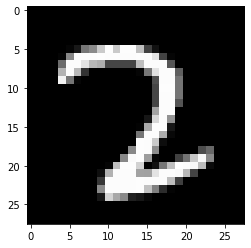

Index: 4157, Prediction: 4, Label: 2


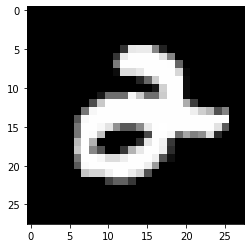

Index: 4160, Prediction: 0, Label: 2


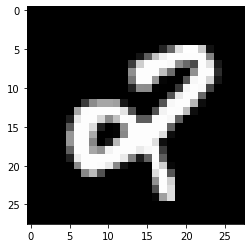

Index: 4172, Prediction: 7, Label: 8


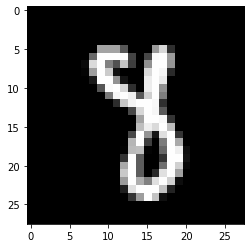

Index: 4184, Prediction: 9, Label: 7


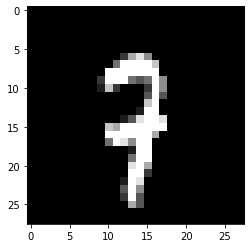

Index: 4232, Prediction: 5, Label: 3


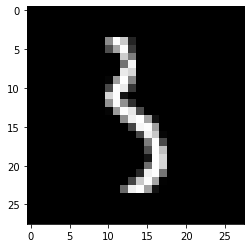

Index: 4233, Prediction: 0, Label: 5


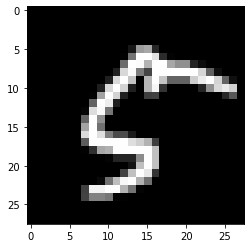

Index: 4237, Prediction: 7, Label: 8


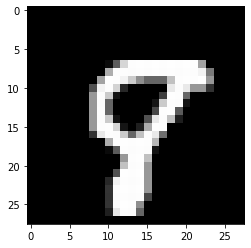

Index: 4284, Prediction: 8, Label: 1


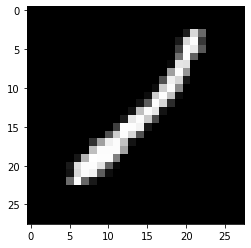

Index: 4323, Prediction: 9, Label: 4


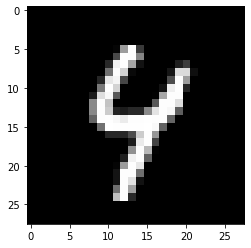

Index: 4338, Prediction: 3, Label: 2


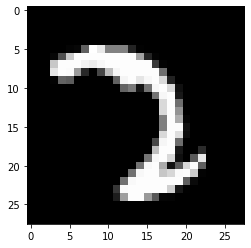

Index: 4355, Prediction: 2, Label: 8


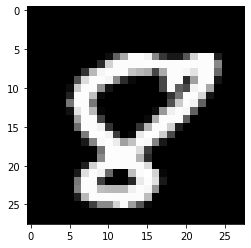

Index: 4377, Prediction: 8, Label: 5


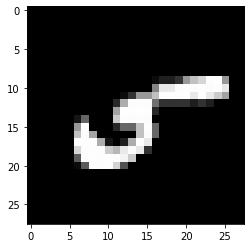

Index: 4386, Prediction: 9, Label: 3


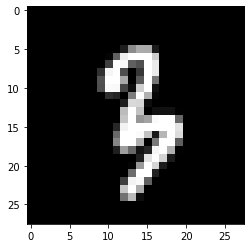

Index: 4417, Prediction: 5, Label: 6


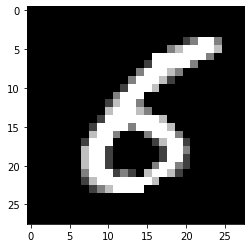

Index: 4425, Prediction: 9, Label: 8


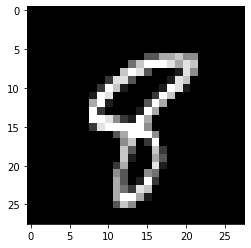

Index: 4434, Prediction: 9, Label: 4


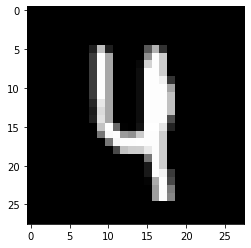

Index: 4462, Prediction: 9, Label: 3


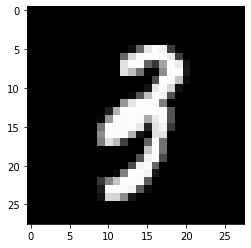

Index: 4480, Prediction: 7, Label: 5


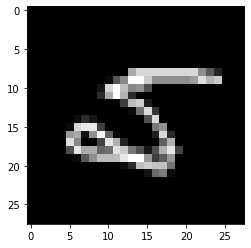

Index: 4487, Prediction: 3, Label: 1


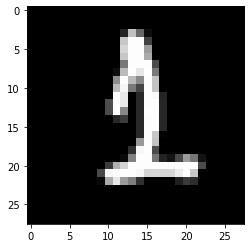

Index: 4496, Prediction: 9, Label: 8


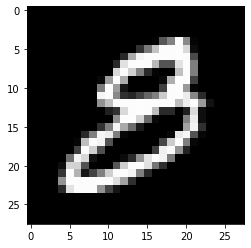

Index: 4514, Prediction: 9, Label: 8


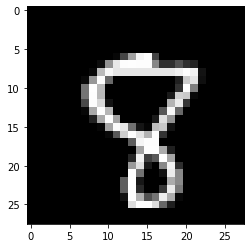

Index: 4525, Prediction: 6, Label: 8


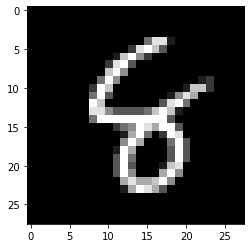

Index: 4530, Prediction: 9, Label: 5


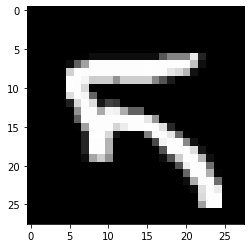

Index: 4531, Prediction: 9, Label: 7


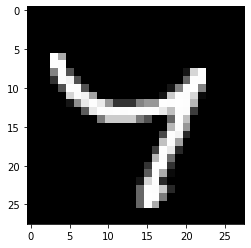

Index: 4536, Prediction: 9, Label: 4


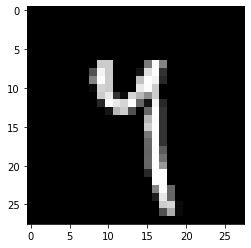

Index: 4537, Prediction: 1, Label: 8


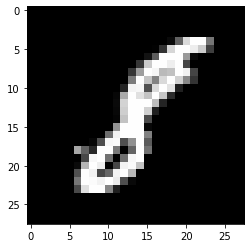

Index: 4546, Prediction: 9, Label: 4


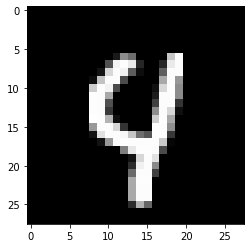

Index: 4573, Prediction: 9, Label: 4


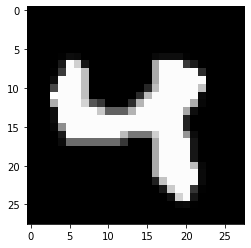

Index: 4581, Prediction: 7, Label: 9


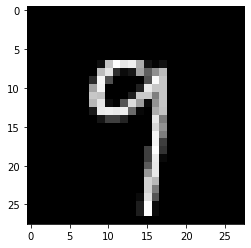

Index: 4599, Prediction: 8, Label: 0


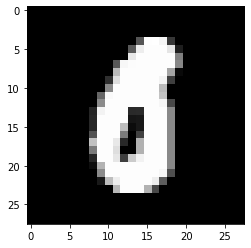

Index: 4605, Prediction: 7, Label: 2


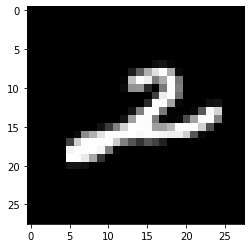

Index: 4608, Prediction: 3, Label: 2


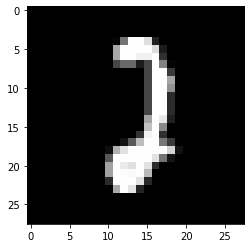

Index: 4647, Prediction: 9, Label: 4


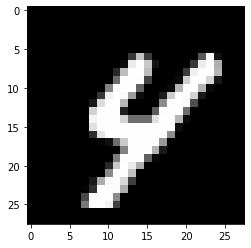

Index: 4665, Prediction: 6, Label: 4


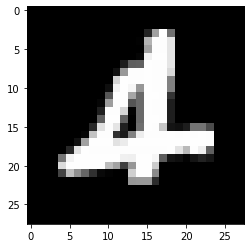

Index: 4671, Prediction: 0, Label: 8


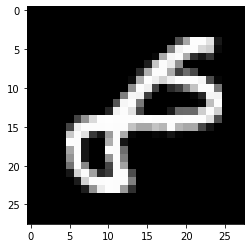

Index: 4679, Prediction: 9, Label: 3


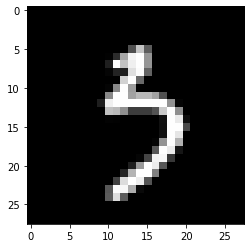

Index: 4707, Prediction: 9, Label: 8


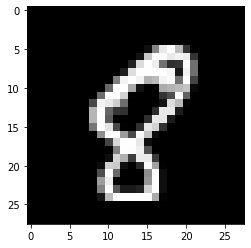

Index: 4716, Prediction: 8, Label: 1


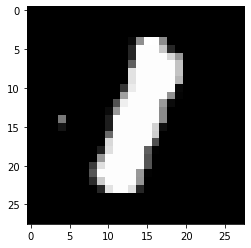

Index: 4733, Prediction: 8, Label: 3


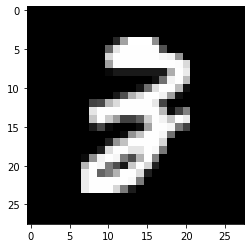

Index: 4754, Prediction: 4, Label: 6


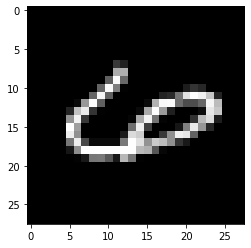

Index: 4786, Prediction: 9, Label: 3


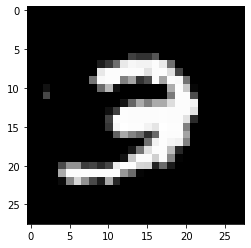

Index: 4787, Prediction: 9, Label: 4


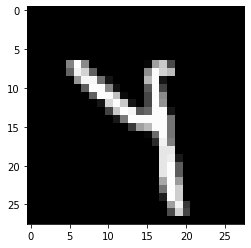

Index: 4793, Prediction: 8, Label: 5


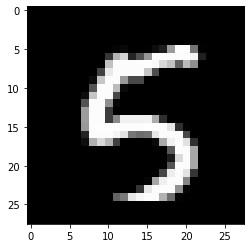

Index: 4808, Prediction: 5, Label: 3


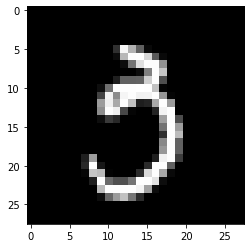

Index: 4821, Prediction: 4, Label: 7


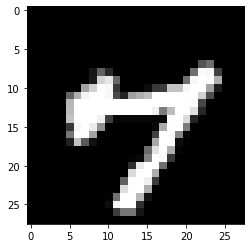

Index: 4873, Prediction: 9, Label: 7


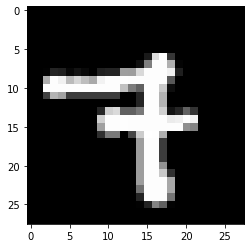

Index: 4890, Prediction: 8, Label: 6


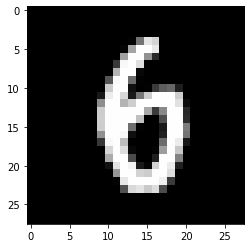

Index: 4894, Prediction: 5, Label: 8


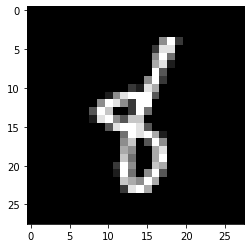

Index: 4905, Prediction: 9, Label: 4


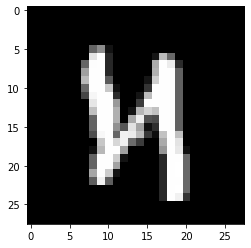

Index: 4908, Prediction: 7, Label: 0


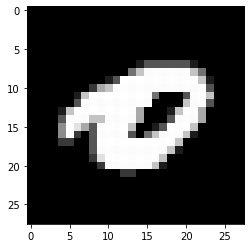

Index: 4924, Prediction: 7, Label: 5


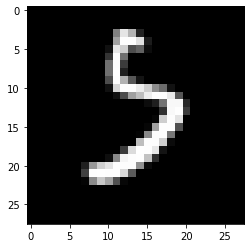

Index: 4930, Prediction: 4, Label: 7


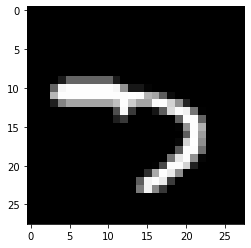

Index: 4965, Prediction: 7, Label: 3


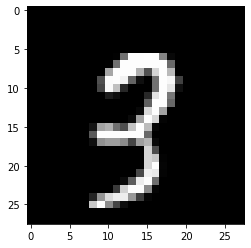

Index: 4987, Prediction: 7, Label: 5


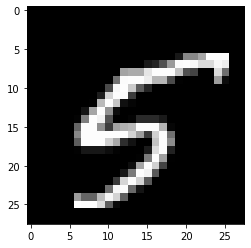

Index: 4997, Prediction: 3, Label: 2


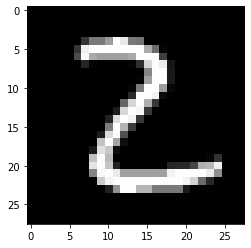

In [22]:
# ---

# This will loop through the first 5000 training samples and display any misclassified images
for i in range(5000):
    show_wrong_prediction(i)

In [23]:
print(f"Correct: {correct*100/5000}, Incorrect: {not_correct*100/5000}")

Correct: 92.84, Incorrect: 7.16
